# Exploring Chinese Restaurants in Boston

In this project, I will explore Chinese restaurants in NYC using Yelp's Fusion API.

## Loading Data

In [1]:
# import necessary libraries
import requests
import json
import folium
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# define function to securely access api_key
def get_key(path):
    with open(path) as f:
        return json.load(f)

In [3]:
api_key = get_key("/Users/yuhaoyang/.secret/yyy.json")['API_key']

In [4]:
# Set necessary parameters
term = "Chinese food"
location = "Boston"
limit = 50
url = "https://api.yelp.com/v3/businesses/search"
headers = {
        'Authorization': f'Bearer {api_key}',
    }
url_params = {'term': term.replace(" ","+"),
             'location': location.replace(" ","+"),
             'limit': limit}

In [5]:
response = requests.get(url, headers=headers, params = url_params)
print(response.status_code)
data = response.json()
print(type(data))

200
<class 'dict'>


In [6]:
data.keys()

dict_keys(['businesses', 'total', 'region'])

In [7]:
data['total']

964

In [8]:
data['region']

{'center': {'longitude': -71.07124328613281, 'latitude': 42.34784169448538}}

### Let's check where the map center is!

In [9]:
long, lat = data['region']['center']['longitude'],data['region']['center']['latitude']

In [10]:
long, lat

(-71.07124328613281, 42.34784169448538)

In [11]:
nyc_map = folium.Map(location=[lat,long], zoom_start=14, tiles='cartodbpositron')
marker = folium.Marker(location = [lat,long])
marker.add_to(nyc_map)

In [12]:
nyc_map

Right around Chinatown!!

### Now, let's keep working on retrieving our data

In [13]:
len(data['businesses'])

50

In [14]:
type(data['businesses'])

list

Due to Yelp API's restrictions, we can only load 50 entries at one time and total access cannot exceed 1000. Therfore, let's import all data by pagination (recursively loading the data and adding it to our dataframe!) while obeying these rules.

In order to load all the data, we set returned entries for each query to the greatest integer divisor (4 in our case) of total number of entries. 

In [15]:
def all_results(url_params, api_key):
    total_num = response.json()['total']
    print(f'There are {total_num} Chinese restaurants in Boston.\nLoading all entries')
    curr = 0
    dfs = []
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': f'Bearer {api_key}'}
    url_params['limit'] = limit
    while curr < total_num:
        url_params['offset'] = curr
        req = requests.get(url, headers=headers, params=url_params)
        dfs.append(pd.DataFrame(req.json()['businesses']))
        time.sleep(1) #Wait a second
        curr += limit
    df = pd.concat(dfs, ignore_index=True)
    return df


In [198]:
df = all_results(url_params, api_key)

There are 964 Chinese restaurants in Boston.
Loading all entries


In [178]:
df.head()

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,hot-eastern-boston-2,"[{'alias': 'szechuan', 'title': 'Szechuan'}]","{'latitude': 42.35161, 'longitude': -71.06095}",(617) 988-0660,945.433806,6yPo1VyadJozt8KBTOhPdQ,https://s3-media4.fl.yelpcdn.com/bphoto/w1mEf8...,False,"{'address1': '42 Beach St', 'address2': 'Ste B...",Hot Eastern,+16179880660,$$,4.0,217,"[delivery, pickup]",https://www.yelp.com/biz/hot-eastern-boston-2?...
1,q-restaurant-boston,"[{'alias': 'chinese', 'title': 'Chinese'}, {'a...","{'latitude': 42.3517075922991, 'longitude': -7...",(857) 350-3968,832.975637,kb0VfKZKHHhvDze3JZqi0Q,https://s3-media1.fl.yelpcdn.com/bphoto/FtV5lG...,False,"{'address1': '660 Washington St', 'address2': ...",Q Restaurant,+18573503968,$$,4.0,939,[delivery],https://www.yelp.com/biz/q-restaurant-boston?a...
2,clay-pot-cafe-boston,"[{'alias': 'cantonese', 'title': 'Cantonese'}]","{'latitude': 42.3504982, 'longitude': -71.0604...",(617) 357-5262,934.491678,wOsTAvCIVjB-fPQBJepMQg,https://s3-media2.fl.yelpcdn.com/bphoto/EHXu_x...,False,"{'address1': '74 Kneeland St', 'address2': '',...",Clay Pot Cafe,+16173575262,$,4.0,273,[],https://www.yelp.com/biz/clay-pot-cafe-boston?...
3,myers-and-chang-boston,"[{'alias': 'asianfusion', 'title': 'Asian Fusi...","{'latitude': 42.3438187315924, 'longitude': -7...",(617) 542-5200,607.031423,72PQGMhrEcIuWH-S44TprA,https://s3-media2.fl.yelpcdn.com/bphoto/ZGXvH3...,False,"{'address1': '1145 Washington St', 'address2':...",Myers & Chang,+16175425200,$$,4.0,1586,[pickup],https://www.yelp.com/biz/myers-and-chang-bosto...
4,chinatown-cafe-boston,"[{'alias': 'chinese', 'title': 'Chinese'}]","{'latitude': 42.3475899, 'longitude': -71.06207}",(617) 695-9888,712.949047,g3OJi94JTYhIoEwqNfhI8g,https://s3-media1.fl.yelpcdn.com/bphoto/VyTsC8...,False,"{'address1': '262 Harrison Ave', 'address2': '...",Chinatown Cafe,+16176959888,$,4.0,168,[],https://www.yelp.com/biz/chinatown-cafe-boston...


Looking neat!

## Preprocessing Data

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 16 columns):
alias            950 non-null object
categories       950 non-null object
coordinates      950 non-null object
display_phone    950 non-null object
distance         950 non-null float64
id               950 non-null object
image_url        950 non-null object
is_closed        950 non-null bool
location         950 non-null object
name             950 non-null object
phone            950 non-null object
price            886 non-null object
rating           950 non-null float64
review_count     950 non-null int64
transactions     950 non-null object
url              950 non-null object
dtypes: bool(1), float64(2), int64(1), object(12)
memory usage: 112.3+ KB


In [19]:
print(f'there are {df.name.nunique()} restaurants')
print(f'there are {df.alias.nunique()} restaurant names')

there are 895 restaurants
there are 950 restaurant names


In [20]:
df.name.value_counts()[:10]

Legal Sea Foods           6
Panda Express             5
Master Wok                4
Bon Me                    3
Flaming Grill & Buffet    3
Dragon Chef               3
Ruby Thai Kitchen         3
China Garden              2
Dumpling House            2
Sichuan Gourmet           2
Name: name, dtype: int64

Let's check for missing values!

In [81]:
[(x, df[x].isnull().sum()) for x in df.columns]

[('alias', 0),
 ('categories', 0),
 ('coordinates', 0),
 ('display_phone', 0),
 ('distance', 0),
 ('id', 0),
 ('image_url', 0),
 ('is_closed', 0),
 ('location', 0),
 ('name', 0),
 ('phone', 0),
 ('price', 64),
 ('rating', 0),
 ('review_count', 0),
 ('transactions', 0),
 ('url', 0)]

In [82]:
food_price = df.price[df.price.isnull() == False]

This is dumb. Since the string "$$" raises an exception in Python, we have to replace it with something else. I'll use "Y".

In [83]:
food_price = pd.Series([x.replace("$","Y") for x in food_price])

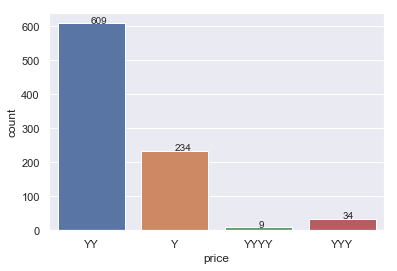

In [99]:
#Plot price with labeling
cplot = sns.countplot(food_price)
plt.xlabel('price')
for i in cplot.patches:
    cplot.annotate(f'{i.get_height()}',(i.get_x() + i.get_width() / 2., i.get_height()))

In [127]:
df = df[df.review_count>20].drop(['phone','display_phone'], axis = 1)

In [131]:
df.drop(['transactions','url','id','image_url'], inplace = True, axis = 1)

In [201]:
df.price.fillna("", inplace = True)

In [203]:
def change_val(x):
    return len(x)

In [204]:
df.price = df.price.apply(lambda x: len(x))

In [206]:
df.head()

,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,hot-eastern-boston-2,"[{'alias': 'szechuan', 'title': 'Szechuan'}]","{'latitude': 42.35161, 'longitude': -71.06095}",(617) 988-0660,945.433806,6yPo1VyadJozt8KBTOhPdQ,https://s3-media4.fl.yelpcdn.com/bphoto/w1mEf8...,False,"{'address1': '42 Beach St', 'address2': 'Ste B...",Hot Eastern,+16179880660,2,4.0,217,"[pickup, delivery]",https://www.yelp.com/biz/hot-eastern-boston-2?...
1,q-restaurant-boston,"[{'alias': 'chinese', 'title': 'Chinese'}, {'a...","{'latitude': 42.3517075922991, 'longitude': -7...",(857) 350-3968,832.975637,kb0VfKZKHHhvDze3JZqi0Q,https://s3-media1.fl.yelpcdn.com/bphoto/FtV5lG...,False,"{'address1': '660 Washington St', 'address2': ...",Q Restaurant,+18573503968,2,4.0,939,[delivery],https://www.yelp.com/biz/q-restaurant-boston?a...
2,clay-pot-cafe-boston,"[{'alias': 'cantonese', 'title': 'Cantonese'}]","{'latitude': 42.3504982, 'longitude': -71.0604...",(617) 357-5262,934.491678,wOsTAvCIVjB-fPQBJepMQg,https://s3-media2.fl.yelpcdn.com/bphoto/EHXu_x...,False,"{'address1': '74 Kneeland St', 'address2': '',...",Clay Pot Cafe,+16173575262,1,4.0,273,[],https://www.yelp.com/biz/clay-pot-cafe-boston?...
3,myers-and-chang-boston,"[{'alias': 'asianfusion', 'title': 'Asian Fusi...","{'latitude': 42.3438187315924, 'longitude': -7...",(617) 542-5200,607.031423,72PQGMhrEcIuWH-S44TprA,https://s3-media2.fl.yelpcdn.com/bphoto/ZGXvH3...,False,"{'address1': '1145 Washington St', 'address2':...",Myers & Chang,+16175425200,2,4.0,1586,[pickup],https://www.yelp.com/biz/myers-and-chang-bosto...
4,chinatown-cafe-boston,"[{'alias': 'chinese', 'title': 'Chinese'}]","{'latitude': 42.3475899, 'longitude': -71.06207}",(617) 695-9888,712.949047,g3OJi94JTYhIoEwqNfhI8g,https://s3-media1.fl.yelpcdn.com/bphoto/VyTsC8...,False,"{'address1': '262 Harrison Ave', 'address2': '...",Chinatown Cafe,+16176959888,1,4.0,168,[],https://www.yelp.com/biz/chinatown-cafe-boston...


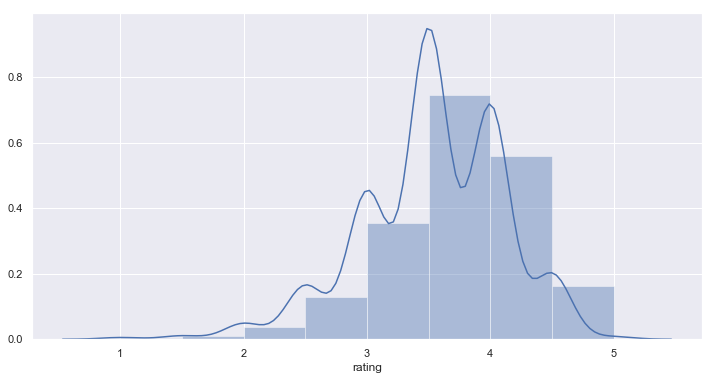

In [207]:
plt.figure(figsize = (12,6))
sns.distplot(df.rating, bins = 8)

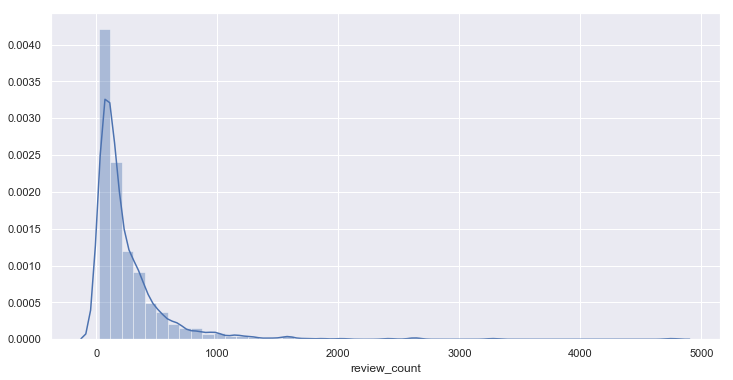

In [154]:
plt.figure(figsize = (12,6))
sns.distplot(df.review_count)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2e6022b0>,
      dtype=object)

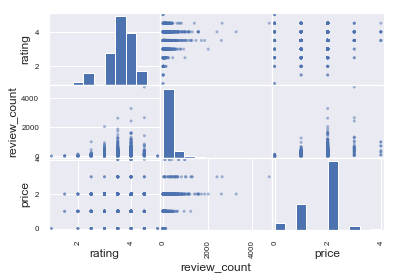

In [209]:
pd.plotting.scatter_matrix(df[['rating', 'review_count','price']])